In [ ]:
# %% Load data and packages

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.fpm import FPGrowth

# Initialize Spark session
spark = SparkSession \
        .builder \
        .appName("genre_analysis-fp growth") \
        .getOrCreate()

24/12/01 21:29:48 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
# %% Load and process data

df = spark.read.csv('/home/mikezhu/data/spotify_data.csv', header=True)

# Convert string representation of list to array
genre_df = df.select(F.from_json(
    F.col('genres'), 
    ArrayType(StringType())
).alias('items'))

In [ ]:
# %% Perform FP-Growth analysis

fp = FPGrowth(minSupport=0.005, minConfidence=0.4)
fpm = fp.fit(genre_df)

In [ ]:
# %% FP-Growth results

print("Frequent Genre Sets:")
fpm.freqItemsets.sort("freq", ascending=False).show()

print("\nGenre Association Rules:")
fpm.associationRules.sort("antecedent", "consequent").show()

Frequent Genre Sets:


+--------------------+-----+
|               items| freq|
+--------------------+-----+
|         [classical]|33064|
|              [rock]|30791|
|               [pop]|22654|
|               [rap]|16691|
|      [classic rock]|16460|
|[classic rock, rock]|13578|
|        [album rock]|12344|
|           [hip hop]|11977|
|         [hard rock]|11709|
|               [edm]|11556|
|         [dance pop]|11395|
|         [soft rock]|11277|
| [alternative metal]|11228|
| [singer-songwriter]|10942|
|         [pop dance]|10746|
|  [album rock, rock]|10459|
|[album rock, clas...|10448|
|    [permanent wave]|10357|
|       [modern rock]|10013|
|      [hip hop, rap]| 9862|
+--------------------+-----+
only showing top 20 rows


Genre Association Rules:
+--------------------+----------------+-------------------+------------------+--------------------+
|          antecedent|      consequent|         confidence|              lift|             support|
+--------------------+----------------+-------------

In [ ]:
# %% Visualization setup

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx

# Convert Spark DataFrame to Pandas
freq_genres = fpm.freqItemsets.toPandas()
rules = fpm.associationRules.toPandas()

# Visualization utilities
def plot_top_n_genres(freq_genres_df, n_genres, top_n=20):
    """
    Plot top N most frequent genre combinations of specified size
    
    Parameters:
    -----------
    freq_genres_df : pandas.DataFrame
        DataFrame containing frequency analysis results
    n_genres : int
        Number of genres in combination (1 for single, 2 for pairs, 3 for triplets)
    top_n : int
        Number of top combinations to plot
    """
    plt.figure(figsize=(12, 6))
    filtered_genres = freq_genres_df[freq_genres_df['items'].apply(len) == n_genres]
    
    if n_genres == 1:
        filtered_genres['label'] = filtered_genres['items'].apply(lambda x: x[0])
        title = f'Top {top_n} Most Frequent Single Genres'
        xlabel = 'Genre'
    else:
        filtered_genres['label'] = filtered_genres['items'].apply(lambda x: ' , '.join(x))
        title = f'Top {top_n} Most Frequent Genre {"Pairs" if n_genres == 2 else "Triplets"}'
        xlabel = f'Genre {"Pairs" if n_genres == 2 else "Triplets"}'
    
    top_genres = filtered_genres.nlargest(top_n, 'freq')
    plt.bar(top_genres['label'], top_genres['freq'])
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
def plot_single_item_rules_network(rules, min_confidence=0.5, top_rules=50, seed=42):
    """
    Optimized single-item association rules network visualization with dynamic node sizes,
    edge transparency, and legend
    
    Parameters:
    -----------
    rules : pandas.DataFrame
        DataFrame containing association rules
    min_confidence : float
        Minimum confidence threshold for filtering rules
    top_rules : int
        Number of top rules to display
    seed : int
        Random seed for reproducible layout
    """
    G = nx.DiGraph()
    
    # Filter rules, keep only single-element antecedent and consequent
    filtered_rules = rules[
        (rules['confidence'] >= min_confidence) & 
        (rules['antecedent'].apply(len) == 1) &
        (rules['consequent'].apply(len) == 1)
    ].nlargest(top_rules, 'confidence')
    
    # Add edges and weights
    for _, rule in filtered_rules.iterrows():
        antecedent = rule['antecedent'][0]
        consequent = rule['consequent'][0]
        G.add_edge(antecedent, consequent, 
                   weight=rule['confidence'], 
                   lift=rule['lift'])
    
    node_sizes = [500 + 1000 * (G.in_degree(node) + G.out_degree(node)) for node in G.nodes()]
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    edge_alphas = [min(0.3 + weight, 1) for weight in weights]
    
    plt.figure(figsize=(15, 10))
    # Add seed parameter for reproducible layout
    pos = nx.spring_layout(G, k=0.6, seed=seed)
    
    nodes = nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=node_sizes, alpha=0.9)
    
    for edge, alpha in zip(G.edges(), edge_alphas):
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[edge],
            edge_color=[G[edge[0]][edge[1]]['weight']],
            edge_cmap=plt.cm.viridis_r,
            edge_vmin=min(weights),
            edge_vmax=max(weights),
            width=2,
            alpha=alpha,
            arrows=True,
            arrowsize=15,
            node_size=node_sizes
        )
    
    # Remove bbox parameter to remove background from labels
    nx.draw_networkx_labels(
        G, pos,
        font_size=9
    )
    
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis_r, norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Confidence', rotation=270, labelpad=15)
    
    plt.title('Single-Item Genre Association Network', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

/scratch/local/jobs/26519979/ipykernel_1798696/3511008508.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_genres['label'] = filtered_genres['items'].apply(lambda x: x[0])


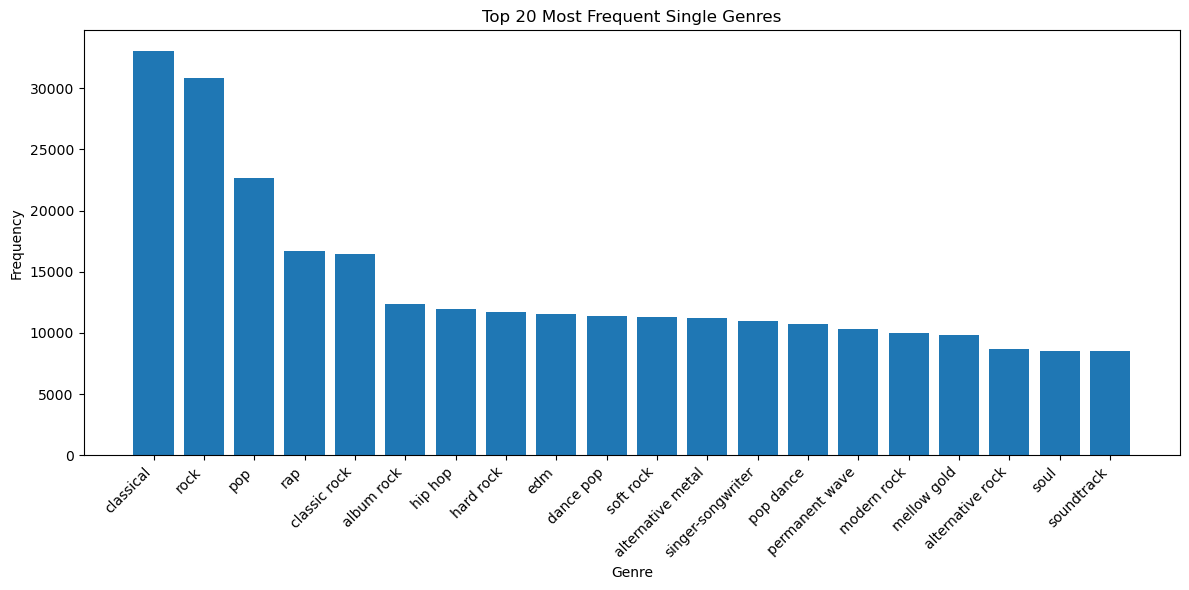

/scratch/local/jobs/26519979/ipykernel_1798696/3511008508.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_genres['label'] = filtered_genres['items'].apply(lambda x: ' , '.join(x))


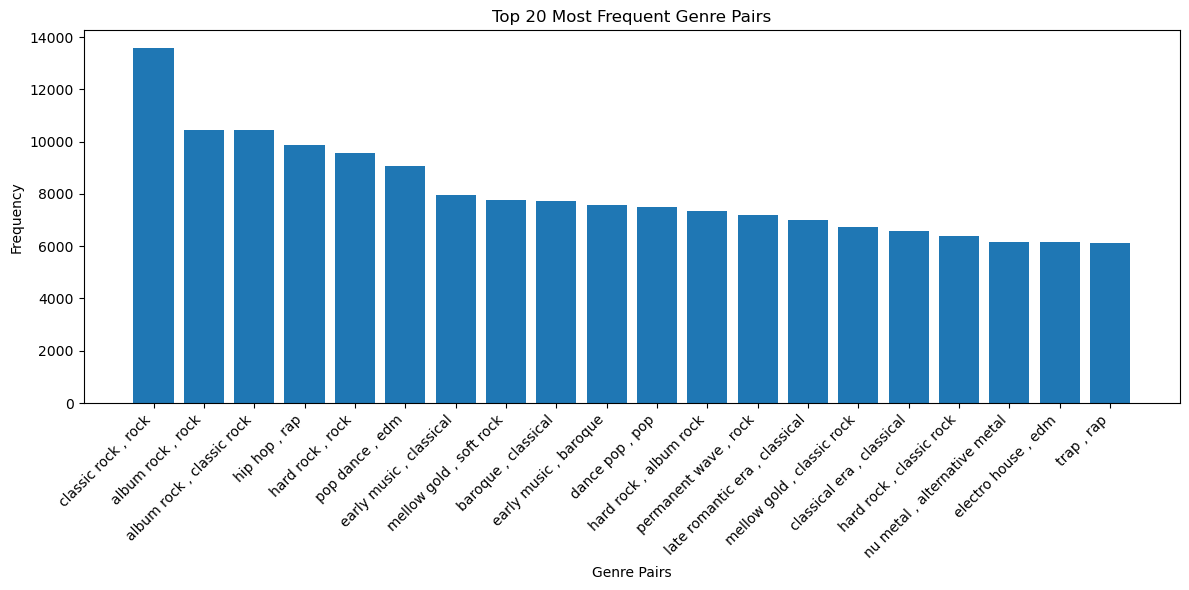

/scratch/local/jobs/26519979/ipykernel_1798696/3511008508.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_genres['label'] = filtered_genres['items'].apply(lambda x: ' , '.join(x))


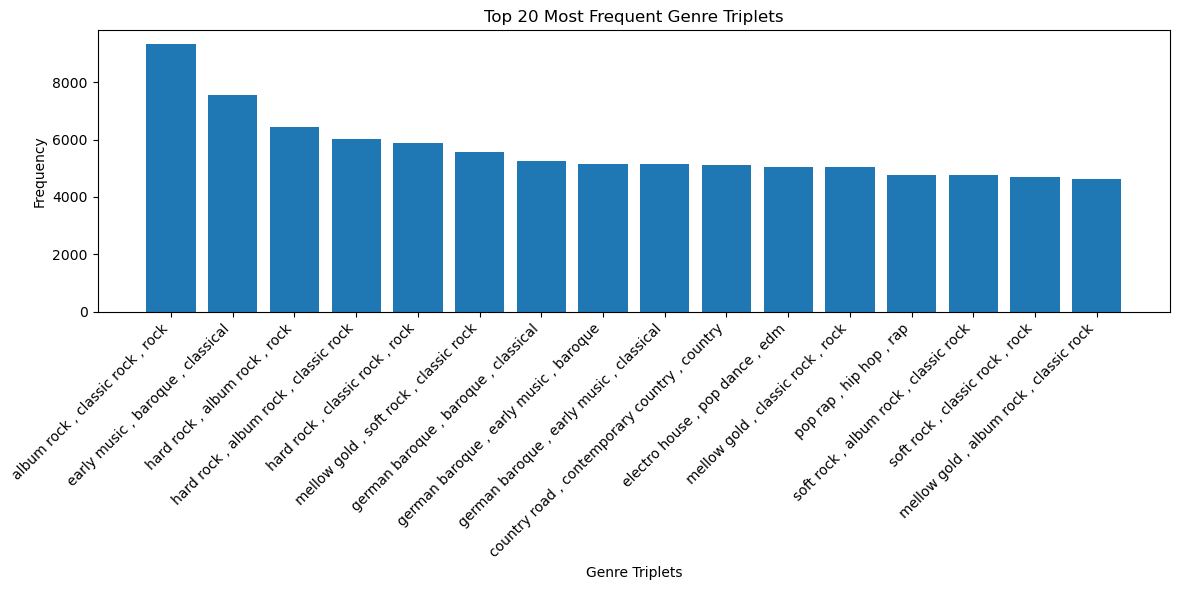

In [ ]:
# %% Plot visualizations

for n in [1, 2, 3]:
    plot_top_n_genres(freq_genres, n)

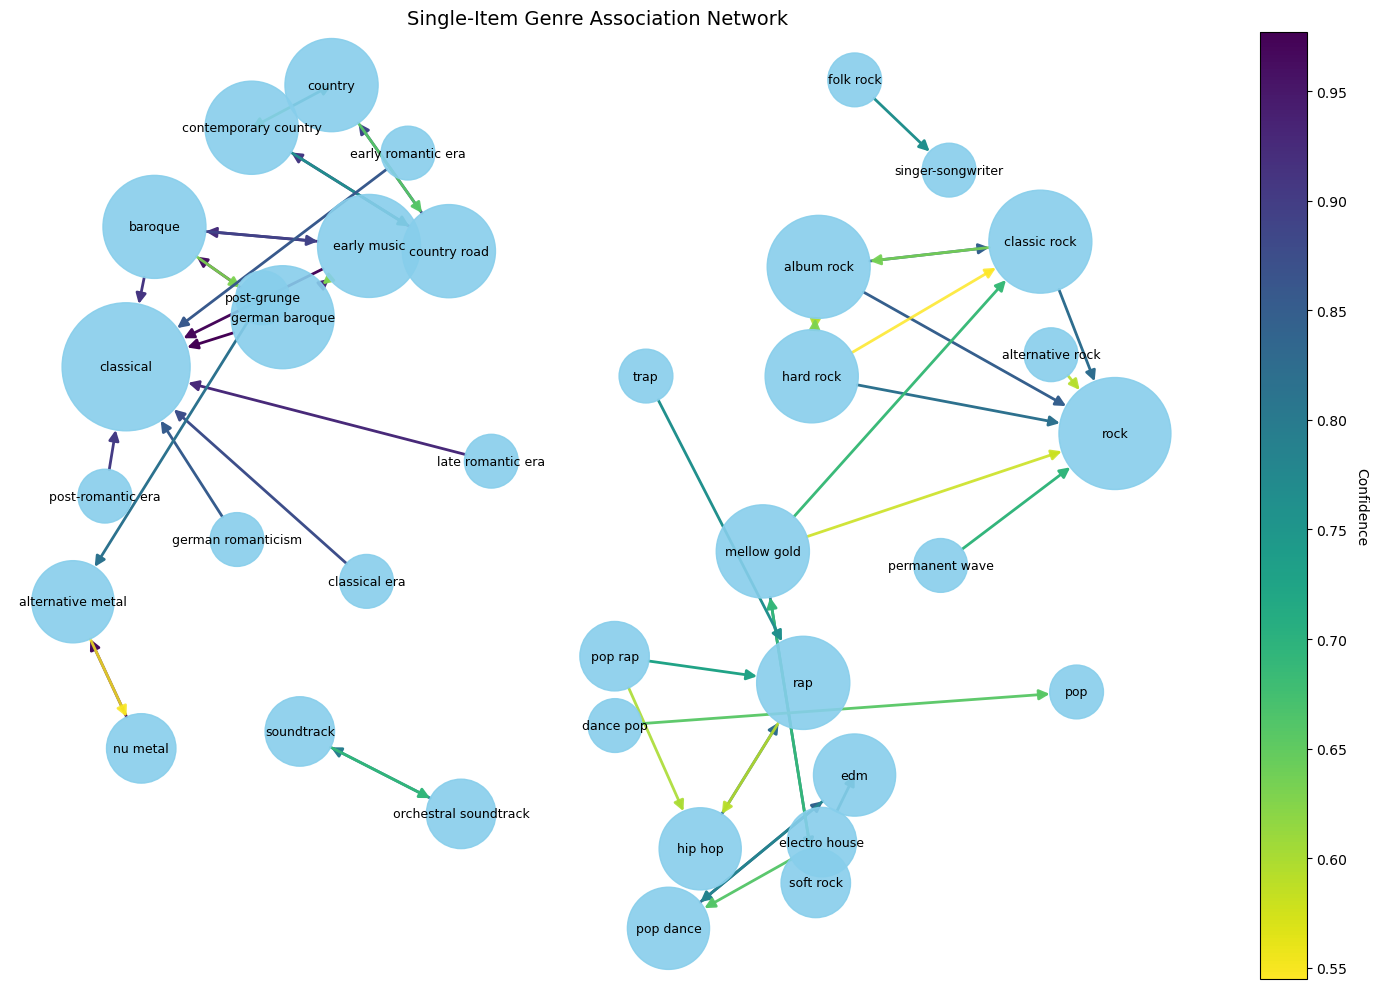

In [ ]:
#%%

plot_single_item_rules_network(rules, min_confidence=0.40, seed=3)